<a href="https://colab.research.google.com/github/yichun-hub/FlickrCrawler-in-Tainan/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparation

####Importing libraries and mounting Google Drive

In [ ]:
# Basic libraries
import os
import pandas as pd
import numpy as np 
from joblib import dump, load
import six
from google.colab import drive
drive.mount('/content/drive')

# Clustering
from sklearn.cluster import DBSCAN, OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import sklearn.utils

# Vizualization
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
%matplotlib inline
from PIL import Image
# Installing cartopy library from command line
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip uninstall shapely
!pip install shapely --no-binary shapely
!pip install cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (105 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency 

####Defining the function needed

In [ ]:
# def make_map(projection=ccrs.PlateCarree()):
#   fig, ax = plt.subplots(figsize=(14, 10),
#                          subplot_kw=dict(projection=projection))
#   gl = ax.gridlines(draw_labels=True)
#   gl.xlabels_top = gl.ylabels_right = False
#   gl.xformatter = LONGITUDE_FORMATTER
#   gl.yformatter = LATITUDE_FORMATTER
#   return fig, ax

def new_get_image(self, tile):
    if six.PY3:
        from urllib.request import urlopen, Request
    else:
        from urllib2 import urlopen
    url = self._image_url(tile)  # added by H.C. Winsemius
    req = Request(url) # added by H.C. Winsemius
    req.add_header('User-agent', 'your bot 0.1')
    # fh = urlopen(url)  # removed by H.C. Winsemius
    fh = urlopen(req)
    im_data = six.BytesIO(fh.read())
    fh.close()
    img = Image.open(im_data)

    img = img.convert(self.desired_tile_form)

    return img, self.tileextent(tile), 'lower'

####Loading the dataset as Panda DataFrame

In [ ]:
root = '/content/drive/MyDrive/Colab Notebooks/Flickr'

# loading the file
geotag_df = pd.read_csv(root+'/CSV/cleancsv/2015.csv')
geotag_df.set_index('photo_id', inplace=True)
print ("Shape of the DataFrame: ", geotag_df.shape)

owner_list = geotag_df.owner_nsid.unique()
owner_df = pd.DataFrame({'owner_nsid': owner_list})
print(owner_df.head())
print(owner_df) ##177

#geotag_test = geotag_df.sample(frac=2, replace=True)
owner_test = owner_df.sample(841)
#print(owner_test)

Shape of the DataFrame:  (11127, 253)
      owner_nsid
0  100410866@N06
1  132201212@N08
2   26526753@N06
3   41311366@N00
4  100280633@N05
        owner_nsid
0    100410866@N06
1    132201212@N08
2     26526753@N06
3     41311366@N00
4    100280633@N05
..             ...
836   13986243@N04
837   92144911@N05
838    8874741@N03
839   86695113@N08
840   97391488@N05

[841 rows x 1 columns]


In [ ]:
# defining the maps border

lower_longitude = 120.033449
upper_longitude = 120.656555
lower_latitude = 22.887501
upper_latitude = 23.413401
'''
### 台南市中心
lower_longitude = 120.078996
upper_longitude = 120.334324
lower_latitude = 22.914592
upper_latitude = 23.088418'''

extent = [lower_longitude, upper_longitude, lower_latitude, upper_latitude]

# Filtering data based on the coordinate
geotag_df = geotag_df.loc[(geotag_df['location_longitude'] > lower_longitude) &
                          (geotag_df['location_longitude'] < upper_longitude) &
                          (geotag_df['location_latitude'] > lower_latitude) &
                          (geotag_df['location_latitude'] < upper_latitude)]
print ("Shape of the DataFrame: ", geotag_df.shape)
geotag_df.head()

Shape of the DataFrame:  (11127, 253)


,owner_nsid,owner_location,dates_taken,location_latitude,location_longitude,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,...,Unnamed: 214,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229,Unnamed: 230,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237,Unnamed: 238,Unnamed: 239,Unnamed: 240,Unnamed: 241,Unnamed: 242,Unnamed: 243,Unnamed: 244,Unnamed: 245,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253
photo_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.60997766e+10,100410866@N06,NaN,2015-01-01,23.266355,120.123352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.60997758e+10,100410866@N06,NaN,2015-01-01,23.266822,120.122811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.66790576e+10,100410866@N06,NaN,2015-01-01,23.267130,120.123469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.60997753e+10,100410866@N06,NaN,2015-01-01,23.267172,120.123752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.93573158e+10,100410866@N06,NaN,2015-01-01,23.266355,120.123352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Visualization

####User Photomap

In [ ]:
i = 0
total_user = len(owner_test.index)
plt.ioff()

for index, row in owner_test.iterrows():
	cimgt.GoogleWTS.get_image = new_get_image
	request = cimgt.GoogleTiles()

	fig = plt.figure(figsize=(9,6))
	mymap = plt.axes(projection=ccrs.PlateCarree())
	mymap.set_extent(extent)
	mymap.add_image(request, 10)
	
	plot_df = geotag_df.loc[geotag_df['owner_nsid'] == row.owner_nsid]
	#print(current_owner_nsid)

	total_nodes = len(geotag_df.index)
	for index,row in plot_df.iterrows():
		mymap.plot(row.location_longitude, row.location_latitude, markerfacecolor = 'blue', markeredgecolor = 'yellow', marker = 's', markersize = 10, alpha = 0.6)
	plt.title("Photo map of user: {0}" .format(row.owner_nsid), fontsize=14)
	#plt.savefig("/content/drive/My Drive/Colab Notebooks/Flickr/MAPs/User_photomap/{0}.png" .format(row.owner_nsid), dpi=300)
	plt.close(fig)
	i += 1
	if i % 50 == 0:
		print('{0} / {1} user photo map created.' .format(i, total_user))
    #plt.show()
print('Total of {0} user photo map created.' .format(i))

50 / 841 user photo map created.
100 / 841 user photo map created.
150 / 841 user photo map created.
200 / 841 user photo map created.
250 / 841 user photo map created.
300 / 841 user photo map created.
350 / 841 user photo map created.
400 / 841 user photo map created.
450 / 841 user photo map created.
500 / 841 user photo map created.
550 / 841 user photo map created.
600 / 841 user photo map created.
650 / 841 user photo map created.
700 / 841 user photo map created.
750 / 841 user photo map created.
800 / 841 user photo map created.
Total of 841 user photo map created.


####Distribution Map

5000 / 11127 nodes plotted to the map.
10000 / 11127 nodes plotted to the map.
Total of 11127 nodes has been plotted to the map.


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


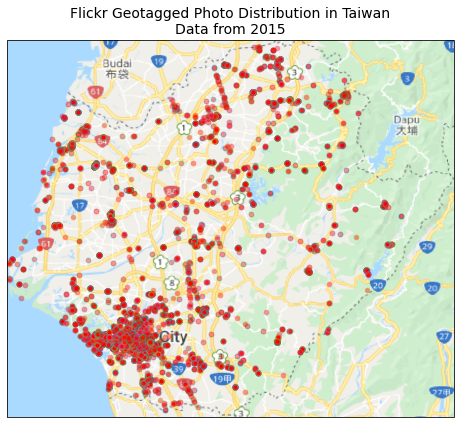

In [ ]:
cimgt.GoogleWTS.get_image = new_get_image
request = cimgt.GoogleTiles()

fig = plt.figure(figsize=(8, 8))
mymap = plt.axes(projection=ccrs.PlateCarree())
mymap.set_extent(extent)
mymap.add_image(request, 10)

i = 0
total_nodes = len(geotag_df.index)
for index,row in geotag_df.iterrows():
    mymap.plot(row.location_longitude, row.location_latitude, markerfacecolor = 'red', marker = '.', markersize = 10, alpha = 0.4)
    i += 1
    if i % 5000 == 0:
        print('{0} / {1} nodes plotted to the map.' .format(i, total_nodes))
print('Total of {0} nodes has been plotted to the map.' .format(i))
#plt.text(x,y,stn)

plt.title("Flickr Geotagged Photo Distribution in Taiwan\nData from 2015", fontsize=14)
#plt.savefig("/content/drive/My Drive/Colab Notebooks/FlickrCrawling/Sarbagita/Maps/Distribution Map.png", dpi=1200)
plt.show()

#Clustering

#####Loading the longitude and latitude data into a new dataframe

In [ ]:
# Taking longitude and latitude data from the geotag_df
geotag_clus = geotag_df[['location_longitude', 'location_latitude']]
print ("Shape of the DataFrame: ", geotag_clus.shape)
print(geotag_clus.head())

# standardize the feature
geotag_clus_scaled = StandardScaler().fit_transform(geotag_clus)
pd.set_option('precision',8)
geotag_clus_scaled = pd.DataFrame(data=geotag_clus_scaled, columns=['location_longitude', 'location_latitude'])
print(geotag_clus_scaled.head())

Shape of the DataFrame:  (11127, 2)
                location_longitude  location_latitude
photo_id                                             
2.60997766e+10          120.123352          23.266355
2.60997758e+10          120.122811          23.266822
2.66790576e+10          120.123469          23.267130
2.60997753e+10          120.123752          23.267172
1.93573158e+10          120.123352          23.266355
   location_longitude  location_latitude
0         -1.22646236         1.51196165
1         -1.23248723         1.51556546
2         -1.22515938         1.51794227
3         -1.22200773         1.51826638
4         -1.22646236         1.51196165


####OPTICS

#####Benchmarking the `min_samples`, `xi`, and `min_cluster_size` to find the optimal parameter

In [ ]:
optics_result = []
i = 0
min_samples = [10, 20, 30]  ##一個範圍內「有多少個點以上」才算密度夠高
xi = [0.05, 0.1]
min_cluster_size = [0.01, 0.5, 0.1]

for x in min_samples:
	for y in xi:
		for z in min_cluster_size:
			optics_model = OPTICS(min_samples=x, xi=y, min_cluster_size=z)

			optics_model.fit(geotag_clus_scaled)
			labels = optics_model.labels_
			if len(set(labels)) < 2:
				n_noise_ = 'Invalid model: Cluster < 2'
				silhouette_score = 'Invalid model: Cluster < 2'
				n_clusters_ = 'Invalid model: Cluster < 2'
				print('Error when trying with the following parameter: min_samples={0}, xi={1}, min_cluster_size={2}' .format(x, y, z))
				break
			else:
				n_noise_ = list(labels).count(-1)
				silhouette_score = metrics.silhouette_score(geotag_clus_scaled, labels)
				n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
				
				result = {'min_samples': x,
									'xi': y,
									'min_cluster_size': z,
									'n_clusters_': n_clusters_,
									'n_noise_': n_noise_,
									'silhouette_score': silhouette_score}
				optics_result.append(result)
				i += 1
				if i % 10 == 0:
					print('%d / 125 model has been made' % i)

optics_benchmark_df = pd.DataFrame(optics_result)
optics_benchmark_df.head()
optics_benchmark_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Flickr/CSV/OPTICS Clustering Benchmark.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904:

10 / 125 model has been made


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904:

#####Clustering the dataset using the `min_samples`, `xi`, and `min_cluster_size` from the benchmarking result

In [ ]:
# Building the OPTICS Clustering model 
min_samples = 30
xi = 0.05
min_cluster_size = 0.01
optics_model = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size) 

# Training the model 
optics_model.fit(geotag_clus_scaled)

# Storing the cluster labels of each point 
labels = optics_model.labels_#[optics_model.ordering_] 
geotag_clus['cluster'] = optics_model.labels_
  
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
silhouette_score = metrics.silhouette_score(geotag_clus_scaled, labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('Silhouette Coefficient: %0.3f' % silhouette_score)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Estimated number of clusters: 37
Estimated number of noise points: 2015
Silhouette Coefficient: 0.058


#####Drawing the cluster on map

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


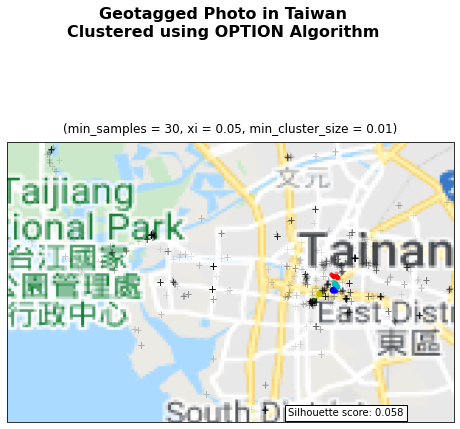

In [ ]:
cimgt.GoogleWTS.get_image = new_get_image
request = cimgt.GoogleTiles()

fig = plt.figure(figsize=(8,8))
mymap = plt.axes(projection=ccrs.PlateCarree())
lower_longitude = 120.124171
upper_longitude = 120.233748 
lower_latitude = 22.957992
upper_latitude = 23.026783
extent = [lower_longitude, upper_longitude, lower_latitude, upper_latitude]
mymap.set_extent(extent)
mymap.add_image(request, 11)

# adding silhouette_score to the plot
props = dict(boxstyle='square', facecolor='white', alpha=1)
mymap.text(0.63, 0.05, 'Silhouette score: %.3f' % silhouette_score, transform=mymap.transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

colors = ['c.', 'b.', 'r.', 'y.', 'g.', 'm.']

for Class, colour in zip(range(0, n_clusters_), colors): 
  Xk = geotag_clus.loc[geotag_clus['cluster'] == Class]
  mymap.plot(Xk['location_longitude'], Xk['location_latitude'], colour, alpha = 0.3) 
geotag_clus['location_longitude'].loc[geotag_clus['cluster'] == -1]
# plotting the outlier
mymap.plot(geotag_clus['location_longitude'].loc[geotag_clus['cluster'] == -1],
           geotag_clus['location_latitude'].loc[geotag_clus['cluster'] == -1], 
           'k+', alpha = 0.1) 

plt.suptitle('Geotagged Photo in Taiwan\nClustered using OPTION Algorithm', fontsize=16, fontweight=600, ha='center', va='top')
plt.title('(min_samples = {0}, xi = {1}, min_cluster_size = {2})' .format(min_samples, xi, min_cluster_size), fontsize=12, ha='center', va='bottom')
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Flickr/MAPs/OPTICS_4({0}, {1}, {2}).png" .format(min_samples, xi, min_cluster_size), dpi=1200)

plt.show()

##### Adding the cluster label to dataframe and exporting it to csv

In [ ]:
# exporting the clustered dataframe into a csv file
clustered_geotag_df = geotag_df
clustered_geotag_df['cluster'] = geotag_clus['cluster']
clustered_geotag_df.to_csv('/content/drive/My Drive/Colab Notebooks/FlickrCrawling/Sarbagita/CSV/2009-2018_Clustered using OPTICS ({0}, {1}, {2}).csv' .format(min_samples, xi, min_cluster_size))

####DBSCAN

#####Benchmarking the `eps` and `min_samples` to find the optimal parameter

In [ ]:
dbscan_result = []
eps = [i for i in np.arange(0.01, 1, 0.01)]
min_samples = [i for i in range(10, 100, 10)]
i = 0
total_combination = len(eps) * len(min_samples)

for x in eps:
  for y in min_samples:
    db = DBSCAN(eps=x, min_samples=y).fit(geotag_clus_scaled)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    if n_clusters_ < 2:
      silhouette_score = 'invalid n_cluster'
    else:
      silhouette_score = metrics.silhouette_score(geotag_clus_scaled, labels)
      
    result = {'eps': x,
              'min_samples': y,
              'n_clusters_': n_clusters_,
              'n_noise_': n_noise_,
              'silhouette_score': silhouette_score}
    dbscan_result.append(result)
    i += 1
    if i % 10 == 0:
      print('{0} / {1} model has been tested' .format(i, total_combination))
    elif  i % total_combination == 0:
      print('Benchmarking done with {0} parameter combination.' .format(total_combination))

dbscan_benchmark_df = pd.DataFrame(dbscan_result)
dbscan_benchmark_df.head()
dbscan_benchmark_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Flickr/CSV/DBSCAN_2015 Clustering Benchmark.csv')

10 / 891 model has been tested
20 / 891 model has been tested
30 / 891 model has been tested
40 / 891 model has been tested
50 / 891 model has been tested
60 / 891 model has been tested
70 / 891 model has been tested
80 / 891 model has been tested
90 / 891 model has been tested
100 / 891 model has been tested
110 / 891 model has been tested
120 / 891 model has been tested
130 / 891 model has been tested
140 / 891 model has been tested
150 / 891 model has been tested
160 / 891 model has been tested
170 / 891 model has been tested
180 / 891 model has been tested
190 / 891 model has been tested
200 / 891 model has been tested
210 / 891 model has been tested
220 / 891 model has been tested
230 / 891 model has been tested
240 / 891 model has been tested
250 / 891 model has been tested
260 / 891 model has been tested
270 / 891 model has been tested
280 / 891 model has been tested
290 / 891 model has been tested
300 / 891 model has been tested
310 / 891 model has been tested
320 / 891 model h

#####Clustering the dataset using the `eps` and `min_samples` from the benchmarking result

In [ ]:
# Setting parameter for DBSCAN
eps = 0.01
min_samples = 10

# Computing DBSCAN
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
db = dbscan_model.fit(geotag_clus_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
geotag_clus['cluster'] = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
silhouette_score = metrics.silhouette_score(geotag_clus_scaled, labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Estimated number of clusters: 166
Estimated number of noise points: 2322
Silhouette Coefficient: 0.257


#####Drawing the cluster on map

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


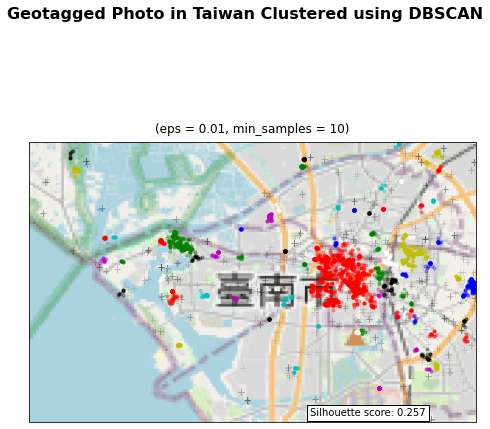

In [ ]:
from itertools import cycle
# Setting parameter for DBSCAN
eps = 0.01
min_samples = 10

cimgt.GoogleWTS.get_image = new_get_image
request = cimgt.OSM()
# request = cimgt.GoogleTiles()

fig = plt.figure(figsize=(8,8))
mymap = plt.axes(projection=ccrs.PlateCarree())

lower_longitude = 120.124171
upper_longitude = 120.233748 
lower_latitude = 22.957992
upper_latitude = 23.026783
extent = [lower_longitude, upper_longitude, lower_latitude, upper_latitude]
mymap.set_extent(extent)
mymap.add_image(request, 11)

# adding silhouette_score to the plot
props = dict(boxstyle='square', facecolor='white', alpha=1)
mymap.text(0.63, 0.05, 'Silhouette score: %.3f' % silhouette_score, transform=mymap.transAxes, fontsize=10,
           verticalalignment='top', bbox=props)


colors = ['c.', 'b.', 'r.', 'y.', 'g.', 'm.', 'w.', 'k.']
colors = cycle(colors)

# plotting cluster
center_point = geotag_clus.groupby('cluster').mean()
for Class, colour in zip(range(0, n_clusters_), colors): 
  Xk = geotag_clus.loc[geotag_clus['cluster'] == Class]
  mymap.plot(Xk['location_longitude'], Xk['location_latitude'], colour, alpha = 0.3)
  #mymap.annotate(str(Class),xy=(center_point.at[Class, 'location_longitude']-0.003,
                                #center_point.at[Class, 'location_latitude']-0.004))
  #mymap.plot(center_point.at[Class, 'location_longitude'],
             #center_point.at[Class, 'location_latitude'],
             #'wo', mec='k', ms=10, alpha=1) 

# plotting outlier
mymap.plot(geotag_clus['location_longitude'].loc[geotag_clus['cluster'] == -1],
           geotag_clus['location_latitude'].loc[geotag_clus['cluster'] == -1], 
           'k+', alpha = 0.1)

plt.suptitle('Geotagged Photo in Taiwan Clustered using DBSCAN', fontsize=16, fontweight=600, ha='center', va='top')
plt.title('(eps = {0}, min_samples = {1})' .format(eps, min_samples), fontsize=12, ha='center', va='bottom')
#plt.savefig("/content/drive/MyDrive/Colab Notebooks/Flickr/MAPs/DBSCAN_2018 ({0}, {1})_1.png" .format(eps, min_samples), dpi=1200)

plt.show()

In [ ]:
center_point.to_csv(root+'/CSV/2015(2)_Clustered centerpoint.csv')

##### Adding the cluster label to dataframe and exporting it to csv

In [ ]:
# exporting the clustered dataframe into a csv file
clustered_geotag_df = geotag_df
clustered_geotag_df['cluster'] = geotag_clus['cluster']
clustered_geotag_df.to_csv(root+'/CSV/2015(2)_Clustered using DBSCAN ({0}, {1}).csv' .format(eps, min_samples))

In [ ]:
print(geotag_clus['cluster'])

photo_id
2.60997766e+10      0
2.60997758e+10      0
2.66790576e+10      0
2.60997753e+10      0
1.93573158e+10      0
                 ... 
2.33754259e+10    136
2.39210893e+10    136
2.38918179e+10     -1
2.33724636e+10     -1
2.39731656e+10     -1
Name: cluster, Length: 11127, dtype: int64


#### Model Reusability

##### Save model

In [ ]:
dump(dbscan_model, root+'/dbscan_model.joblib')

['/content/drive/MyDrive/Colab Notebooks/Flickr/dbscan_model.joblib']

##### Load model

In [ ]:
# Computing DBSCAN
loaded_model = load(root+'/dbscan_model.joblib')
db = loaded_model.fit(geotag_clus_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
geotag_clus['cluster'] = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
silhouette_score = metrics.silhouette_score(geotag_clus_scaled, labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score)

Estimated number of clusters: 76
Estimated number of noise points: 654
Silhouette Coefficient: 0.413


In [ ]:
# exporting the clustered dataframe into a csv file
clustered_geotag_df = geotag_df
clustered_geotag_df['cluster'] = geotag_clus['cluster']
clustered_geotag_df.to_csv(root+'/CSV/2019_Clustered using DBSCAN ({0}, {1}).csv' .format(0.4, 1800))

clustered_geotag_df.head()

,owner_nsid,owner_location,dates_taken,location_latitude,location_longitude,cluster
photo_id,,,,,,
47180980900,8771119@N02,Tainan Taiwan,2019/1/1 00:00,22.991104,120.205053,0
47139285500,8771119@N02,Tainan Taiwan,2019/1/1 00:00,22.991104,120.205053,0
33047492400,8771119@N02,Tainan Taiwan,2019/1/1 00:00,22.991104,120.205053,0
32718144200,8771119@N02,Tainan Taiwan,2019/1/1 00:00,22.991104,120.205053,0
44745110800,8771119@N02,Tainan Taiwan,2019/1/1 00:00,22.991104,120.205053,0
